In [206]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import numpy as np
import cv2
import os
%matplotlib inline
import numpyro
import pyro.distributions as dist
import numpyro
import numpyro.distributions as n_dist
import PyQt5
import skimage.morphology as morph
import skimage
import pickle
from dataProcessing import *

%matplotlib inline

In [208]:
### Load data ####
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
spatialDownsamplingFactor=4
noVideos=2

dataPath='data/usliverseq-mp4'
videoList = loadData(dataPath,timeResolution,spatialDownsamplingFactor=spatialDownsamplingFactor,noVideos=noVideos)

### Get affine transformation ###

ptsArray = np.load('transPts.npz')["arr_0"]/spatialDownsamplingFactor

# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1

videoTransList = getAffineTrans(videoList,ptsArray,refIdx)

### Mask everything outside field of view and smooth pixels out ###

# Define smoothing parameter sigma
sigma=(0,3,3) # Do not smooth over temporal dim, only spatial
videoTransMaskList, morphsInput, vidMasks = maskAndSmooth(videoTransList,sigma)


Loading video 1/2..
    Spatial resolution before spatial downsampling: 712 x 480
    No. of frames before temporal downsampling: 4372
    Downsampling from 25 to 14 frames per second
    Spatial resolution before spatial downsampling: 178 x 120
    No. of frames after temporal downsampling: 2436

Loading video 2/2..
    Spatial resolution before spatial downsampling: 700 x 480
    No. of frames before temporal downsampling: 4625
    Downsampling from 16 to 14 frames per second
    Spatial resolution before spatial downsampling: 175 x 120
    No. of frames after temporal downsampling: 4046



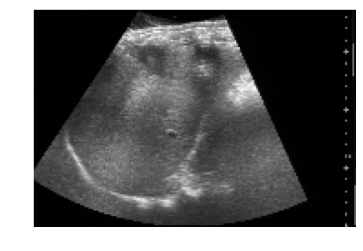

In [12]:
# Run example of video


videoIdx = 0 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

vidShow=videoList[videoIdx][:noFrames]
for i in range(noFrames):
    plt.imshow(vidShow[i],cmap='gray')
    plt.show()
    clear_output(wait=True)

Text(0.5, 1.0, 'Final processed video')

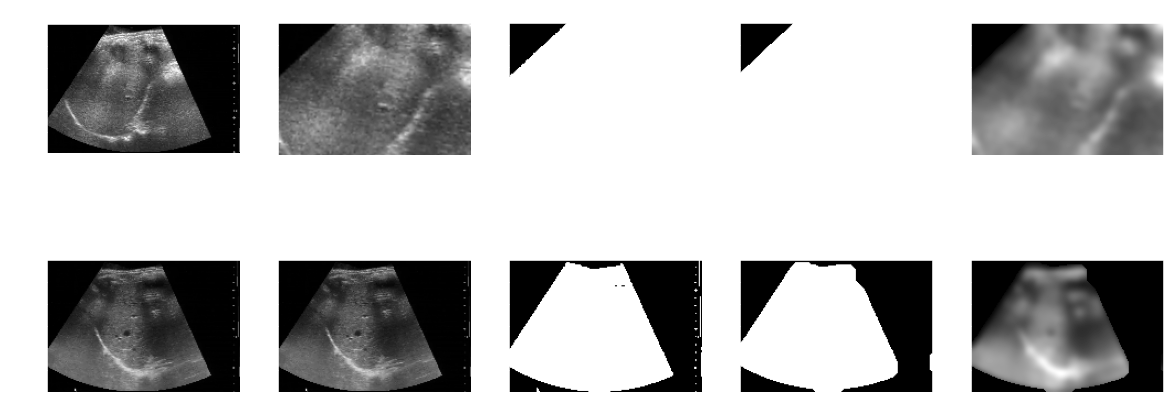

In [3]:
fig,ax = plt.subplots(len(videoList),5,figsize=(20,4*len(videoList)))
for vidIdx in range(len(videoList)):
        ax[vidIdx,0].imshow(videoList[vidIdx][0],cmap='gray')
        ax[vidIdx,1].imshow(videoTransList[vidIdx][0],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(vidMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videoTransMaskList[vidIdx][0],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Affine transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')


# Setup model

In [207]:
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from jax import random
import time
from numpyro.infer import MCMC, NUTS, init_to_feasible

In [201]:
# Carry function
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = jnp.matmul(beta,z_prev)+noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [202]:
def model(T, T_forecast, output_dim, obs=None,latent_dim=2):

    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """

    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros((latent_dim,latent_dim)), scale=jnp.ones((latent_dim,latent_dim))))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(latent_dim)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.5))
    z_prev = numpyro.sample(name="z_prev", fn=dist.Normal(loc=jnp.zeros(latent_dim), scale=jnp.ones(latent_dim)))
    h_matrix = numpyro.sample(name="h_matrix", fn=dist.Normal(loc=jnp.ones((output_dim,latent_dim)),scale=1))
    
    """
    Define LKJ prior
    """

    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(latent_dim, 50.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(latent_dim), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """

    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = jax.lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """
    #print('z_col shape', z_collection.shape)
    #print("z2", z_collection[2])
    #print((jnp.matmul(h_matrix, z_collection[:T].T)).T)
    #print("H", h_matrix.shape)
    #print("z", z_collection[:T].T.shape)
    #mu = jnp.matmul(h_matrix, z_collection[:T].T).T
    #print("mu", jnp.nan_to_num(mu))  

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=(jnp.nan_to_num(jnp.matmul(h_matrix, z_collection[:T].T)).T), scale = sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=(jnp.nan_to_num(jnp.matmul(h_matrix, z_collection[T:].T)).T), scale = sigma), obs=None) 
 

    return z_collection

# Test model with sin curves

In [86]:
N = 300
test_x = np.linspace(0,60,N)
test_y = np.sin(test_x) + np.random.normal(0,0.5,N)
for i in range (1,4):
    test_y = np.vstack((test_y, np.sin(test_x) + np.random.normal(0,0.5,N)))


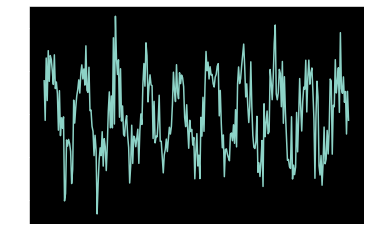

In [87]:
plt.plot(test_y[2])

In [88]:
t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model,init_strategy=init_to_feasible())
mcmc_sin = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc_sin.run(rng_key_, T=N, T_forecast=100, output_dim=test_y.T.shape[1], obs=test_y.T)
t_fin = time.time()
print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [03:48<00:00,  8.76it/s, 1023 steps of size 1.02e-03. acc. prob=0.71]


Total time: 3.907m


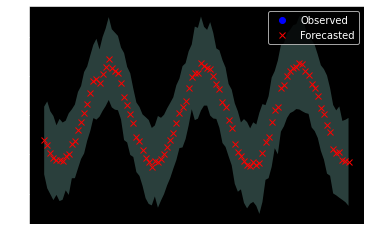

In [89]:
samples_sin = {k:v for k, v in mcmc_sin.get_samples().items()}
idx = 1

# get mean and standard devitions for predictions
y_mean = samples_sin["y_pred"][:,:,idx].mean(axis=0)
y_std = samples_sin["y_pred"][:,:,idx].std(axis=0)

y_pred_025 = y_mean - 1.96*y_std
y_pred_975 = y_mean + 1.96*y_std

plt.plot(range(800,N),test_y[idx].T[800:N],"bo")
plt.plot(range(N,N+100),y_mean.T,"rx")
plt.fill_between(range(N,N+100), y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["Observed","Forecasted"])
plt.show()


# Model for videoData

In [213]:
# Video_input_data: 

vid = videoTransMaskList[1][:1000,90:95,90:95]
test_vid = videoTransMaskList[1][1000:1200,90:95,90:95]
vidMean = (vid-vid.mean(axis=0)) /np.std(vid,axis=0)
data_input = vidMean.reshape(1000,-1) 


Text(0.5, 1.0, 'Visualisation of patch')

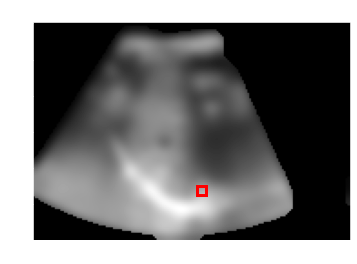

In [191]:
fig, ax = plt.subplots()
ax.imshow(videoTransMaskList[1][0,:,:],cmap = "gray")
ax.add_patch(patch.Rectangle((90,90),5,5,linewidth=3,edgecolor ='r',facecolor ='none'),)
ax.set_title( "Visualisation of patch")


Text(0.5, 1.0, 'Pixel mean over time for patch')

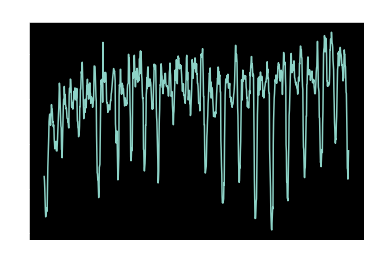

In [192]:
plt.figure()
plt.plot(data_input.mean(axis=1))
plt.title("Pixel mean over time for patch")

In [ ]:

plt.figure()
plt.plot(vid[:,1,1])
#plt.plot(vid[1,:,:].reshape(1,-1)[0,:],'rx')
plt.figure()
#plt.plot(vidMean[1,:,:].reshape(1,-1)[0,:],'rx')
plt.plot(vidMean[:,1,1])


plt.figure()
plt.imshow(vidMean[2],cmap='gray')
plt.figure()
plt.imshow(vid[2],cmap="gray")

In [204]:

t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model,init_strategy=init_to_feasible())
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=data_input.shape[0], T_forecast=200, output_dim=data_input.shape[1], obs=data_input,latent_dim=5)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [41:26<00:00,  1.24s/it, 1023 steps of size 7.66e-04. acc. prob=0.81]  


Total time: 41.653m


# Evaluating results of model

In [205]:
## Save the samples for later use: 
samples = {k:v for k, v in mcmc.get_samples().items()}
print(samples['y_pred'].shape)
import pickle
with open('samples_5x5.pkl', 'wb') as f:
    pickle.dump(samples, f)



(1000, 200, 25)


In [203]:
#Load the samples: 
with open("samples_5x5.pkl","rb") as f:
    data = pickle.load(f)

In [204]:
#Mean the samples: 
ys = data["y_pred"] 
mean_ys = ys.mean(axis=0)
mean_ys = mean_ys.reshape(mean_ys.shape[0],5,5)
final_pred = mean_ys * np.std(vid) + vid.mean(axis=0)

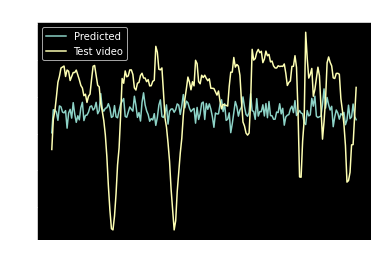

In [214]:
plt.figure()
plt.plot(final_pred.mean(axis=(1,2)))
plt.plot(test_vid.mean(axis=(1,2)))
plt.title("Mean of predicted frame over time")
plt.legend(["Predicted","Test video"])

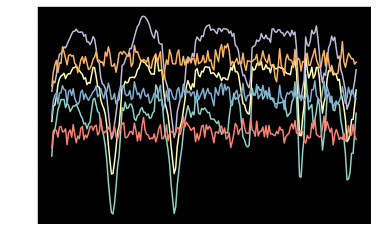

In [216]:
plt.figure()
plt.plot(test_vid[:,[2,3,4],[2,3,4]])
plt.plot(final_pred[:,[2,3,4],[2,3,4]])

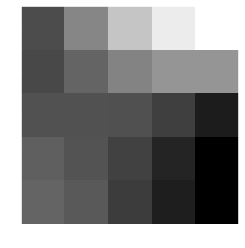

In [221]:
plt.imshow(mean_ys[0],cmap="gray")

(1000, 25, 2) h_matrix


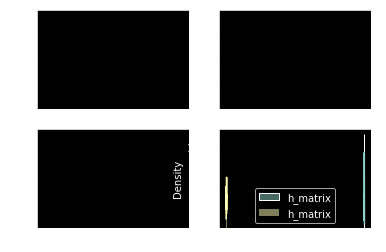

(1000, 2) tau


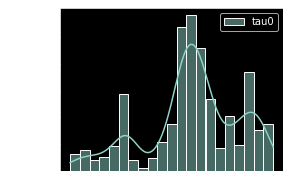

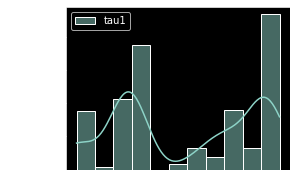

(1000, 2, 2) beta


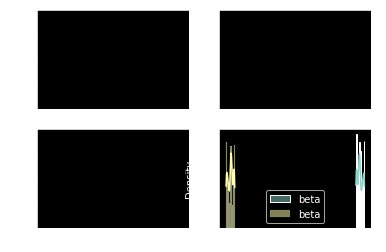

In [522]:
import seaborn as sns
nodes = ["h_matrix", "tau","beta"]
for node in nodes:
  if node in ("tau"):
    print(samples[node].shape,node)
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.histplot(samples[node][:,i], label=node+"%d"%i, kde=True, stat="density")
      plt.legend()
    plt.show()
  else:
    print(samples[node].shape,node)
    fig, axs = plt.subplots(2,2)
    for i in range(2):
      axs[i] = sns.histplot(samples[node][:,i,i], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()